# Auto MPG Project

## Initialization

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from collections import deque
from ucimlrepo import fetch_ucirepo

## Define a Class for doing the task

In [14]:
np.random.seed(2500)


class NonlinearRegression(object):
    def __init__(self, kernel_type='poly'):
        self.kernel_type = kernel_type
        if kernel_type == 'grbf':
            self._flagrbf = 0

    def _fit(self, phi, y):
        self._flag = 1
        self.weights = np.dot(np.linalg.inv(np.dot(phi.T, phi)), np.dot(phi.T, y))

    def _polynomialmodel(self, X, Q):
        self._polydegree = Q
        row, columns = X.shape
        phi = deque()
        phi.append(np.ones(row))
        for degree in range(1, self._polydegree + 1):
            for col in range(columns):
                phi.append(X[:, col] ** degree)
        return np.array(phi).T

    def _gaussianmodel(self, X, Q, s=2):
        self._nbasisfuncs = Q
        row, columns = X.shape
        phi = deque()
        phi.append(np.ones(row))
        if self._flagrbf == 0:
            row, column = X.shape
            index = np.random.choice(row, size=self._nbasisfuncs, replace=False)
            self.mu = X[index, :]
        else:
            self.mu = self.mu
        for number in range(len(self.mu)):
            phi.append([np.exp(-np.linalg.norm(i - self.mu[number]) ** 2 / (2 * s ** 2)) for i in X])
        return np.array(phi).T

    def fit(self, X, y, Q):
        if self.kernel_type == 'poly':
            phi = self._polynomialmodel(X, Q)
            self._fit(phi, y)
        elif self.kernel_type == 'grbf':
            phi = self._gaussianmodel(X, Q)
            self._flagrbf = 1
            self._fit(phi, y)
        else:
            raise ValueError('The entered basis function is not supported in the present form!')

    def predict(self, Xte):
        if self._flag == 1:
            if self.kernel_type == 'poly':
                return self._polynomialmodel(Xte, self._polydegree).dot(self.weights)
            elif self.kernel_type == 'grbf':
                return self._gaussianmodel(Xte, self._nbasisfuncs).dot(self.weights)
            else:
                raise ('The enterd kernels is not supporsted by the presented form!')
        else:
            raise ('You need to fit the model at first!')


class Regularization(NonlinearRegression):
    def __init__(self, landa, kernel_type='poly'):
        super().__init__(kernel_type)
        self.landa = landa

    def _fit(self, phi, y):
        self._flag = 1
        if self.kernel_type == 'poly':
            self.weights = np.dot(np.linalg.inv(np.dot(phi.T, phi) + self.landa * np.eye(phi.shape[1])),
                                  np.dot(phi.T, y))
        else:
            self.weights = np.dot(np.linalg.pinv(np.dot(phi.T, phi) + self.landa * np.eye(phi.shape[1])),
                                  np.dot(phi.T, y))

    def fit(self, X, y, Q):
        if self.kernel_type == 'poly':
            phi = self._polynomialmodel(X, Q)
            self._fit(phi, y)
        elif self.kernel_type == 'grbf':
            phi = self._gaussianmodel(X, Q)
            self._flagrbf = 1
            self._fit(phi, y)
        else:
            raise ValueError('The entered basis function is not supported in the present form!')



## Define the evaluation Criterion

In [15]:
def mean_of_sum_squared(y_true, y_pre):
    return 0.5 * np.mean((y_true - y_pre) ** 2)

## Load Data

In [16]:
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes) 
X = auto_mpg.data.features
y = auto_mpg.data.targets


{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

In [19]:
data = pd.concat([X, y], axis=1)
data

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0
...,...,...,...,...,...,...,...,...
393,140.0,4,86.0,2790,15.6,82,1,27.0
394,97.0,4,52.0,2130,24.6,82,2,44.0
395,135.0,4,84.0,2295,11.6,82,1,32.0
396,120.0,4,79.0,2625,18.6,82,1,28.0


## Missing Value finding

In [21]:
index = np.where(data.notnull() == False)
index

(array([ 32, 126, 330, 336, 354, 374], dtype=int64),
 array([2, 2, 2, 2, 2, 2], dtype=int64))

In [22]:
data.iloc[126]

displacement     200.0
cylinders          6.0
horsepower         NaN
weight          2875.0
acceleration      17.0
model_year        74.0
origin             1.0
mpg               21.0
Name: 126, dtype: float64

In [23]:
data.dropna(inplace=True)
data.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0


## Train and Test Spliting

In [27]:
X = data.drop(columns='mpg', inplace=False).values
y = data['mpg'].values
np.random.seed(2)
X, y = shuffle(X, y)
train_size = 200
Xtrain = X[0:train_size, ]
Xtest = X[train_size:, ]
ytrain = y[0:train_size, ]
ytest = y[train_size:, ]
Ntre = len(ytrain)
Nte = len(ytest)

## Data Normalization

In [38]:
scaler_X = StandardScaler().fit(Xtrain)
scaler_y = StandardScaler().fit(ytrain.reshape(-1, 1))
Xtrain, Xtest = scaler_X.fit_transform(Xtrain), scaler_X.fit_transform(Xtest)
ytrain, ytest = scaler_y.fit_transform(ytrain.reshape(-1, 1)), scaler_y.fit_transform(ytest.reshape(-1, 1))

## Curve fiting

In [66]:
model = NonlinearRegression(kernel_type='poly')
model.fit(Xtrain, ytrain, Q=2)

In [63]:
model.weights

array([[-3.25042707e-16],
       [ 1.43663382e-01],
       [-3.70568972e-02],
       [-3.04490656e-02],
       [-7.36765992e-01],
       [ 1.01313511e-02],
       [ 3.33204529e-01],
       [ 1.36177258e-01]])

## Model Evaluation

In [64]:
y_pre_tr = model.predict(Xtrain)
y_pre_te = model.predict(Xtest)

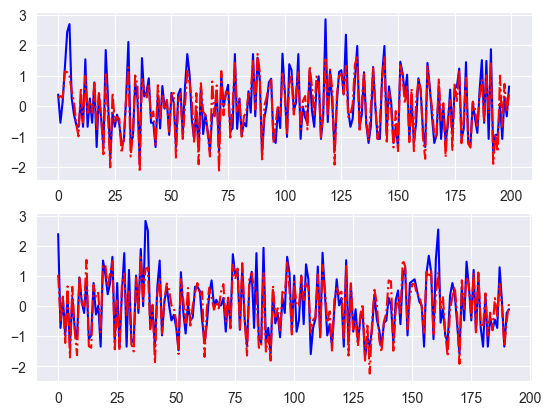

In [65]:
plt.subplot(211)
plt.plot(ytrain, 'b-')
plt.plot(y_pre_tr, 'r-.')
plt.subplot(212)
plt.plot(ytest, 'b')
plt.plot(y_pre_te, 'r-.')
plt.show()

## Elbow Method

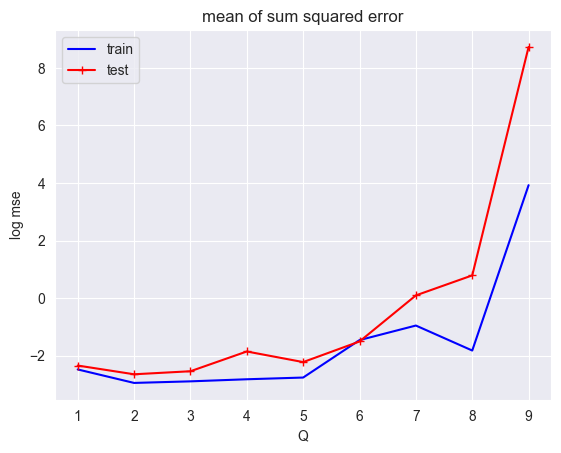

In [72]:
mse_te = []
mse_tr = []
q_range = range(1, 10, 1)
for q in q_range:
    model.fit(Xtrain, ytrain, Q=q)
    y_pre_tr = model.predict(Xtrain)
    y_pre_te = model.predict(Xtest)
    mse_tr.append(mean_of_sum_squared(y_pre_tr, ytrain))
    mse_te.append(mean_of_sum_squared(y_pre_te, ytest))

plt.plot(range(1, 10, 1), np.log(mse_tr), 'b-')
plt.plot(range(1, 10, 1), np.log(mse_te), 'r-+')
plt.legend(['train', 'test'])
plt.title('mean of sum squared error')
plt.xlabel('Q')
plt.ylabel('log mse')
plt.show()

## RBF

In [73]:
model = NonlinearRegression(kernel_type='grbf')
model.fit(Xtrain, ytrain, Q=5)

## Model Evaluation

In [74]:
y_pre_tr = model.predict(Xtrain)
y_pre_te = model.predict(Xtest)

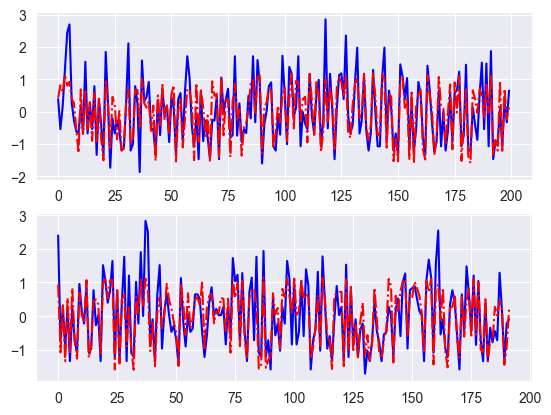

In [75]:
plt.subplot(211)
plt.plot(ytrain, 'b-')
plt.plot(y_pre_tr, 'r-.')
plt.subplot(212)
plt.plot(ytest, 'b')
plt.plot(y_pre_te, 'r-.')
plt.show()

## Elbow Method

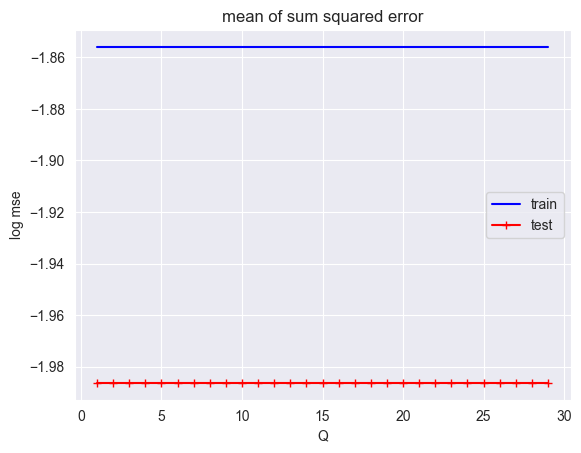

In [82]:
mse_te = []
mse_tr = []
q_range = range(1, 30, 1)
for q in q_range:
    model.fit(Xtrain, ytrain, Q=q)
    y_pre_tr = model.predict(Xtrain)
    y_pre_te = model.predict(Xtest)
    mse_tr.append(mean_of_sum_squared(y_pre_tr, ytrain))
    mse_te.append(mean_of_sum_squared(y_pre_te, ytest))

plt.plot(range(1, 30, 1), np.log(mse_tr), 'b-')
plt.plot(range(1, 30, 1), np.log(mse_te), 'r-+')
plt.legend(['train', 'test'])
plt.title('mean of sum squared error')
plt.xlabel('Q')
plt.ylabel('log mse')
plt.show()

## Curve fitting using built-in function

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
def polynomialmodel(X, Q):
    row, columns = X.shape
    phi = deque()
    phi.append(np.ones(row))
    for degree in range(1, Q + 1):
        for col in range(columns):
            phi.append(X[:, col] ** degree)
    return np.array(phi).T

In [85]:
phi_train = polynomialmodel(Xtrain, Q=2)
phi_test = polynomialmodel(Xtest, Q=2)

In [86]:
model = LinearRegression()
model.fit(phi_train, ytrain)

LinearRegression()

In [89]:
model.coef_

array([[ 0.        , -0.12924484,  0.04305275, -0.37268688, -0.51094863,
        -0.09593679,  0.33758207,  0.0724232 ,  0.03744088,  0.03889678,
         0.04734693,  0.16529416,  0.03676239,  0.11768003, -0.01813051]])

In [90]:
model.intercept_

array([-0.42529066])

In [92]:
y_pre_tr = model.predict(phi_train)
y_pre_te = model.predict(phi_test)

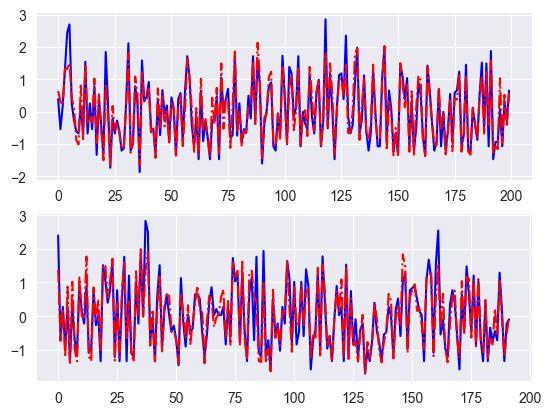

In [93]:
plt.subplot(211)
plt.plot(ytrain, 'b-')
plt.plot(y_pre_tr, 'r-.')
plt.subplot(212)
plt.plot(ytest, 'b')
plt.plot(y_pre_te, 'r-.')
plt.show()

## Regularization

In [106]:
model = Regularization(landa=0.5, kernel_type='poly')
model.fit(Xtrain, ytrain, Q=10)

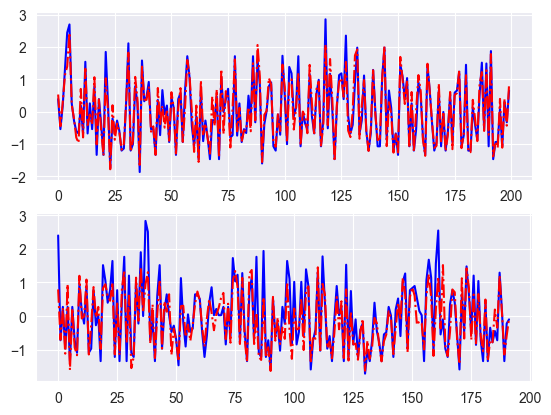

In [107]:
y_pre_tr = model.predict(Xtrain)
y_pre_te = model.predict(Xtest)
plt.subplot(211)
plt.plot(ytrain, 'b-')
plt.plot(y_pre_tr, 'r-.')
plt.subplot(212)
plt.plot(ytest, 'b')
plt.plot(y_pre_te, 'r-.')
plt.show()

## Curve fitting using built-in function

In [108]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.001)

In [109]:
model.fit(phi_train , ytrain)

Ridge(alpha=0.001)

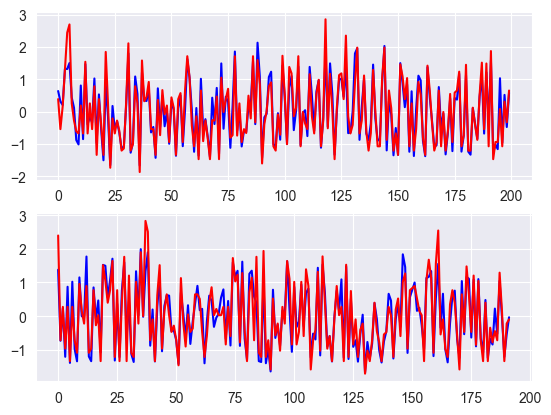

In [110]:
y_pre_tr = model.predict(phi_train)
y_pre_te = model.predict(phi_test)
plt.subplot(211)
plt.plot(y_pre_tr, 'b-')
plt.plot(ytrain, 'r')
plt.subplot(212)
plt.plot(y_pre_te, 'b')
plt.plot(ytest, 'r')
plt.show()

## L1 Regularization

In [114]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.01)

In [115]:
model.fit(phi_train , ytrain)

Lasso(alpha=0.01)

In [116]:
model.coef_

array([ 0.        , -0.03026255, -0.        , -0.21001553, -0.62685729,
       -0.02280934,  0.33321381,  0.05658754,  0.03340579,  0.00760093,
        0.0097931 ,  0.17812936,  0.03083714,  0.10661808,  0.        ])

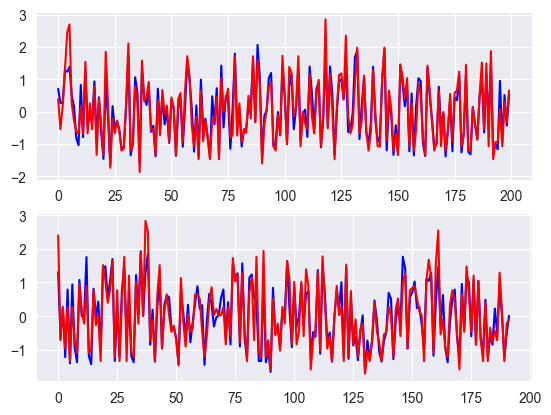

In [117]:
y_pre_tr = model.predict(phi_train)
y_pre_te = model.predict(phi_test)
plt.subplot(211)
plt.plot(y_pre_tr, 'b-')
plt.plot(ytrain, 'r')
plt.subplot(212)
plt.plot(y_pre_te, 'b')
plt.plot(ytest, 'r')
plt.show()